In [1]:
import torch
import torch_geometric
import torch.nn as nn
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
import networkx as nx
from typing import Literal

from torch_geometric.datasets import ExplainerDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.datasets.motif_generator import HouseMotif
import torch_geometric.transforms as T

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(evaluation)

<module 'evaluation' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\evaluation.py'>

In [2]:
batch_size = 1

learning_rate_gnn = 0.001        #0.001 on ADAM
epochs_gnn = 1000
early_stopping = 500

loss = nn.CrossEntropyLoss()           # cross entropy loss?!

datasetName: Literal['BA-Shapes', 'BA-Community', 'Tree-Cycles', 'Tree-Grid'] = 'Tree-Cycles'

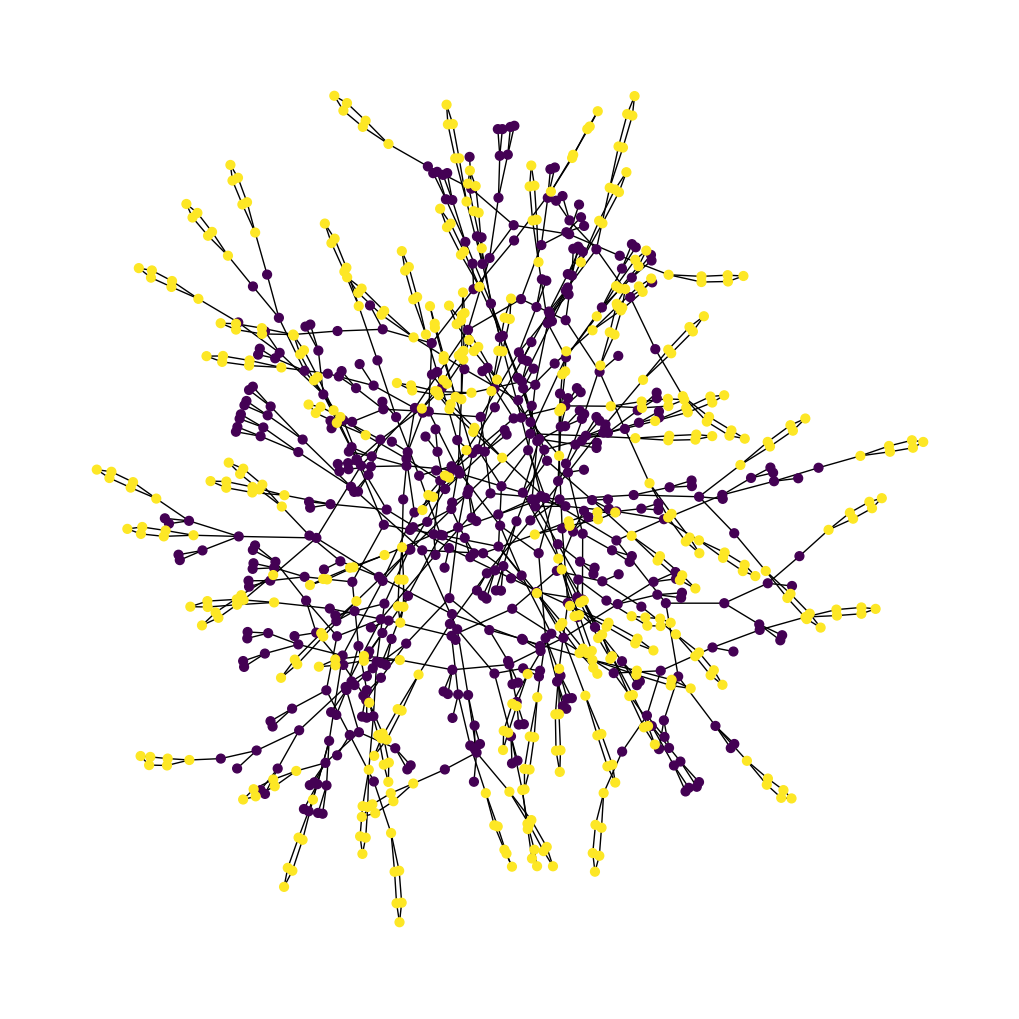

In [3]:
labels, data = datasetLoader.loadNodeDataset(datasetName)

colors = []

for i, j in enumerate(data.y):
    colors.append([j.item()])

g = torch_geometric.utils.to_networkx(data, to_undirected=True)

pos = nx.spring_layout(g, seed=42)          # try kamada_kawai_layout
plt.figure(figsize=(10, 10))  # You can adjust the size as needed

nx.draw(g, pos, node_size=40,font_size=8, node_color = colors)

#trainLoader = DataLoader(data, 1, True)

In [10]:
print(data.x)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


In [4]:
print(data)
print(data.edge_index.shape)
print(data.y)
print(data)

train_data_y = data.y[data.train_mask]
print(train_data_y.shape)

train_data = data.subgraph(data.train_mask)
print(train_data)
print(len(train_data.y))

print(len(data.y[data.train_mask]))
print(data.x.shape)
print(data.x)

Explanation(edge_index=[2, 1630], y=[991], edge_mask=[1630], node_mask=[991], x=[991, 10], train_mask=[991], val_mask=[991], test_mask=[991])
torch.Size([2, 1630])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
gnn = networks.NodeGNN(features = data.x.shape[1], labels=labels)       # temp.y.shape[0] is wrong!!! TODO: how do I get #labels from loader?? take from loader.dataset? Store with dataset

gnn_optimizer = torch.optim.Adam(params = gnn.parameters(), lr = learning_rate_gnn)

print(f"Training on Graph with {len(data.y)} nodes")

train_mask = data.train_mask

early_stop_counter = 0
min_val_loss = 1000.0
best_val_acc = 0
best_epoch = 0

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

for epoch in range(0, epochs_gnn) :
    print(f'\n------------------ EPOCH {epoch + 1} -------------------')

    gnn.train()

    train_acc_sum = 0
    num_batches = 1.0
    train_loss = 0.0

    gnn_optimizer.zero_grad()       # Reset parameters

    # get model embeddings (node representations)?
    out = gnn.forward(data.x, data.edge_index)

    # calc cross entropy loss between real label and predicted label
    currLoss = loss(out[train_mask], data.y[train_mask])

    currLoss.backward()
        
    torch.nn.utils.clip_grad_norm_(gnn.parameters(), max_norm=2)    # clip gradient above 2(for ba2motfis according to reimplementation) to stop "overlearning"?

    gnn_optimizer.step()

    # predicted labels
    preds = out[train_mask].argmax(dim=1)
    train_acc_sum = torch.sum(preds == data.y[train_mask])
        
    train_loss =  currLoss.item()                    # use currLoss.item() instead of currLoss for numeric value

    final_train_acc = train_acc_sum/len(data.y[train_mask])





    gnn.eval()

    # avg loss
    print(f"average training loss: {train_loss}, training acc: {final_train_acc}")    # TODO: train_loss = currLoss; currLoss is loss over all nodes, need to divide by size?!!?

    train_losses.append(train_loss)
    train_accuracies.append(final_train_acc)

    val_acc, valLoss = evaluation.evaluateNodeGNN(gnn, data, data.val_mask)
    print(f"validation loss: {valLoss}, validation acc: {val_acc}")

    val_losses.append(valLoss)
    val_accuracies.append(val_acc)

    # TODO: early stopping

Training on Graph with 991 nodes

------------------ EPOCH 1 -------------------
average training loss: 5.069230556488037, training acc: 0.5170239806175232
validation loss: 4.38393497467041, validation acc: 0.5555555820465088

------------------ EPOCH 2 -------------------
average training loss: 4.592456817626953, training acc: 0.5170239806175232
validation loss: 3.9347660541534424, validation acc: 0.5555555820465088

------------------ EPOCH 3 -------------------
average training loss: 4.123814582824707, training acc: 0.5170239806175232
validation loss: 3.492617130279541, validation acc: 0.5555555820465088

------------------ EPOCH 4 -------------------
average training loss: 3.662445545196533, training acc: 0.5170239806175232
validation loss: 3.056856632232666, validation acc: 0.5555555820465088

------------------ EPOCH 5 -------------------
average training loss: 3.2077348232269287, training acc: 0.5170239806175232
validation loss: 2.627255916595459, validation acc: 0.5555555820465

### Save Model

In [9]:
torch.save(gnn.state_dict(), f"models/TreeCycles test 99")

### Calculate test accuracy and loss

In [7]:
gnn.eval()

test_acc, testLoss = evaluation.evaluateNodeGNN(gnn, data, data.train_mask)
print(f"test loss: {testLoss}, test acc: {test_acc}")

test loss: 0.015806782990694046, test acc: 0.9936948418617249


### Plot Losses

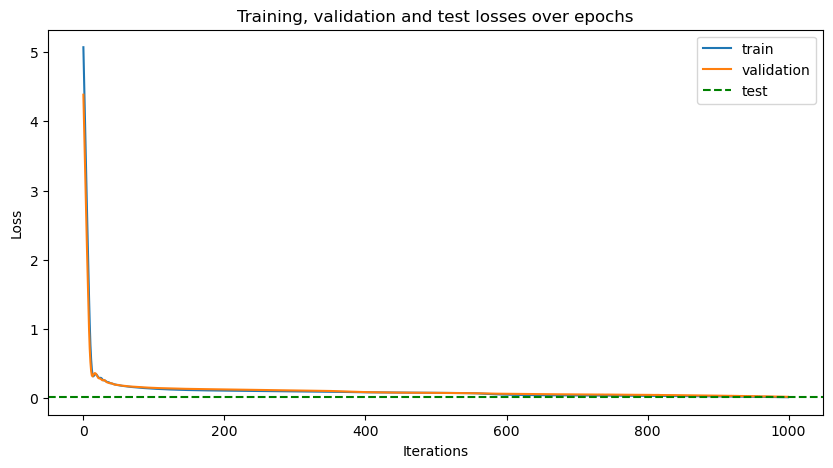

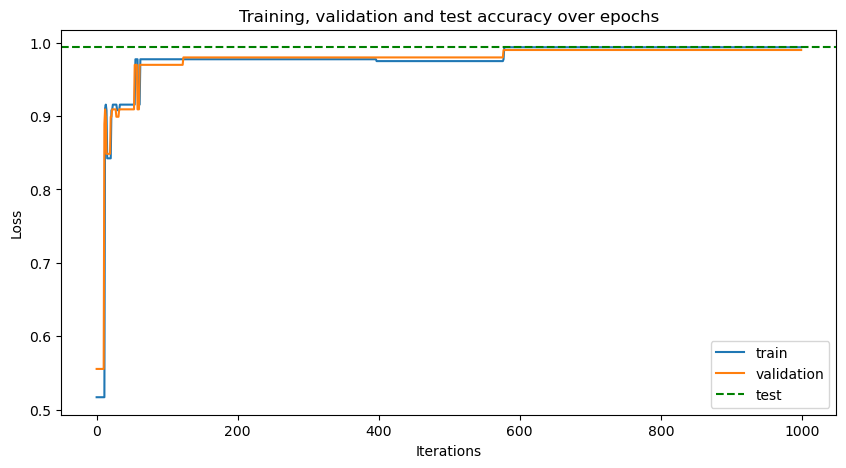

In [8]:
#   Losses
plt.figure(figsize=(10, 5))
plt.title("Training, validation and test losses over epochs")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.axhline(y=testLoss, linestyle='dashed', color = "green", label = "test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#   Accuracy
plt.figure(figsize=(10, 5))
plt.title("Training, validation and test accuracy over epochs")
plt.plot(train_accuracies, label="train")
plt.plot(val_accuracies, label="validation")
plt.axhline(y=test_acc, linestyle='dashed', color = "green", label = "test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Construct a base Barabási–Albert (BA) graph.

Construct a set of five-node house-structured network motifs.

Attach the motifs to randomly selected nodes of the base graph.

Perturb the graph by adding random edges.

Nodes are assigned to 4 classes. Nodes of label 0 belong to the base BA graph. Nodes of label 1, 2, 3 are separately at the middle, bottom, or top of houses.

Generate normally distributed features of length 10

Repeat the above steps to generate another graph. Its nodes are assigned to class 4, 5, 6, 7. Its node features are generated with a distinct normal distribution.

Join the two graphs by randomly adding edges between them.

In [412]:
dataset1 = ExplainerDataset(
            graph_generator=BAGraph(300, 1),
            motif_generator=HouseMotif(),
            num_motifs=80,
            num_graphs=1,
            transform=T.Constant()      # TODO: use 2 gaussian distributions
        )
dataset2 = ExplainerDataset(
            graph_generator=BAGraph(300, 1),
            motif_generator=HouseMotif(),
            num_motifs=80,
            num_graphs=1,
            transform=T.Constant()      # TODO: use 2 gaussian distributions
        )

In [ ]:
import torch
from torch_geometric.data import Data

# Assuming graph1 and graph2 are already defined as Data objects

# Combine node features
x_combined = torch.cat([graph1.x, graph2.x], dim=0)  # Concatenate along node dimension

# Combine edge indices
edge_index_combined = torch.cat([graph1.edge_index, graph2.edge_index + graph1.num_nodes], dim=1)
# Add graph1.num_nodes to graph2's edge indices to avoid overlap

# Combine node labels (y)
y_combined = torch.cat([graph1.y, graph2.y], dim=0)

# Combine node masks
node_mask_combined = torch.cat([graph1.node_mask, graph2.node_mask], dim=0)

# Combine edge masks
edge_mask_combined = torch.cat([graph1.edge_mask, graph2.edge_mask], dim=0)

# Create a new Data object for the combined graph
combined_graph = Data(
    x=x_combined, 
    edge_index=edge_index_combined, 
    y=y_combined, 
    edge_mask=edge_mask_combined, 
    node_mask=node_mask_combined
)

# Now, combined_graph contains the merged data
